# Análise Titanic (Parte 3)- Escolha dos Hiperparâmetros


Neste notebook iremos continuar com a análise de dados dos passageiros do Titanic. Agora iremos trabalhar com a escolha dos hiperparâmetros dos modelos.


## Etapa inicial - Baixar os dados e tratá-los

In [1]:
import pandas as pd

dados = pd.read_excel('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls')
## Criar variável "familia" como a soma entre 'sibsp' e 'parch'
dados['familia'] = dados['sibsp'] + dados['parch'] 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dados.iloc[:,dados.columns.values !='survived'], dados['survived'], test_size=0.33, random_state=42)

## Inserir Idades faltantes com a Mediana
X_train['age'].fillna(X_train['age'].median(), inplace = True)
X_test['age'].fillna(X_test['age'].median(), inplace = True)

#Criar dummies
X_train = pd.get_dummies(X_train, columns=["pclass","sex"])
X_test = pd.get_dummies(X_test, columns=["pclass","sex"])

#Apagar as dummies que servirão de base
del X_train['sex_female']
del X_train['pclass_1']

del X_test['sex_female']
del X_test['pclass_1']

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Tabela com resultados finais
resultados_acuracia = pd.DataFrame(columns = ['modelo', 'acuracia'])

## Exemplo de escolha dos hiperparâmetros do KNN

O modelo KNN tem como hiperparâmetro o número de "vizinhos" (neighbors) que é definido no momento que criamos o 'objeto' do sklearn. Por exemplo, ao criarmos uma instância do knn que utilize os 3 vizinhos mais próximos:

In [2]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

Para escolher o melhor hiperparâmetro "vizinhos" iremos utilizar o que é chamado de Validação Cruzada (Cross Validation)


## Cross Validation

A ideia é separar a base de dados em grupos de treinamento e grupos de teste. O modelo a ser avaliado é ajustado com os dados presentes no grupo de treinamento e, depois, a performance do modelo ajustado é avaliada com os dados presentes no grupo de teste. A performance do modelo é a média dos resultados obtidos em cada rodada de treinamento.
Existem diversas maneiras de fazer a separação entre dados de treinamento e teste. 
Dentre elas, temos:

### K-Fold

Dividiremos a base de dados em K partições ('folds') e realizaremos K rodadas de treinamento e teste do modelo com essas combinações de dados. 

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0041.png")


### Shuffle Split

Iremos dividir a base em um número definido de divisões treino/teste. As amostras são embaralhadas e depois divididas nos pares de treino/teste


In [4]:
Image(url= "https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0061.png")

Outras metodologias de Cross Validation, como Leave One Out Cross Validation (LOOCV), estão descritas em

https://scikit-learn.org/stable/modules/cross_validation.html

Para encontrar o melhor hiperparâmetro do KNN, iremos buscar qual tem melhor desepenho em um processo de Cross Validation.
O Scikit Learn permite realizar essa busca de duas maneiras: GridSearch (onde todos os hiperparâmetros serão testados) e RandomizedSearch (onde os hiperparâmetros serão buscados de maneira aleatória). Este último para casos onde a quantidade de hiperparâmetros inviabilizaria o cálculo de todas as combinações possíveis.



In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit

# KNN a ser utilizado
knn = KNeighborsClassifier()

# Todos os parâmetros a serem testados
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

# Cross Validation com o Shuffle Split
cross_validation = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

best_knn = GridSearchCV(knn, parameters, cv= cross_validation)
best_knn.fit(X_train[['pclass_2','pclass_3','age','sex_male','familia']],y_train)

# Qual melhor hiperparâmetro
best_knn.best_params_

{'n_neighbors': 5}

No caso, o melhor hiperparâmetros para o KNN é de 5

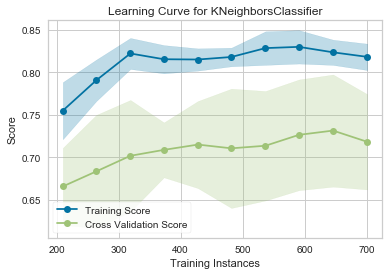

In [12]:
import numpy as np
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve

sizes = np.linspace(0.3, 1.0, 10)

viz = LearningCurve(KNeighborsClassifier(), cv=5, train_sizes=sizes,
    scoring='f1_weighted', n_jobs=4)

viz.fit(X_train[['pclass_2','pclass_3','age','sex_male','familia']], y_train)
viz.poof()


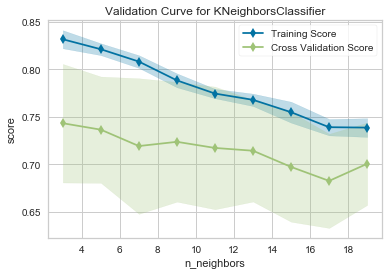

In [13]:

viz = ValidationCurve(KNeighborsClassifier(), param_name="n_neighbors",
    param_range= np.arange(3, 20, 2), cv=10, scoring="f1_weighted", n_jobs = 4)

# Fit and poof the visualizer
viz.fit(X_train[['pclass_2','pclass_3','age','sex_male','familia']], y_train)
viz.poof()

## Busca dos melhores hiperparâmetros para SVM

In [7]:
from sklearn.model_selection import KFold
from sklearn import svm

kf = KFold(n_splits=10)

parameters = {'kernel':('linear', 'rbf'), 'C':[1,2,3,4,5,6,7,8,9,10], 'degree': [2,3,4,5]}

svc = svm.SVC()

best_svm = GridSearchCV(svc, parameters, cv=kf)
best_svm.fit(X_train[['pclass_2','pclass_3','age','sex_male','familia']],y_train)

best_svm.best_params_

{'C': 4, 'degree': 2, 'kernel': 'rbf'}